# Sistema Híbrido de Clasificación de Documentos

Este notebook implementa un sistema híbrido que combina dos enfoques de clasificación de documentos:
1. **Modelo basado en OCR + NLP**: Extrae texto de imágenes y clasifica usando embeddings de texto
2. **Modelo basado en CNN (ResNet50)**: Clasifica documentos directamente desde las imágenes

El sistema final puede clasificar 6 tipos diferentes de documentos combinando las fortalezas de ambos enfoques.

## 1. Configuración Inicial del Entorno

### 1.1 Montaje de Google Drive
Para acceder a los datasets almacenados en Google Drive, primero montamos la unidad en el entorno de Colab.

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### 1.2 Instalación de Dependencias para OCR

Instalamos Tesseract OCR y las librerías de Python necesarias para el procesamiento de imágenes y extracción de texto:
- **tesseract-ocr**: Motor de OCR de Google
- **pytesseract**: Wrapper de Python para Tesseract
- **pillow**: Librería para manipulación de imágenes

In [ ]:
!apt-get install tesseract-ocr -y
!apt-get install libtesseract-dev -y
!pip install pytesseract
!pip install pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 3,743 kB of archives.
After this operation, 16.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1.5 [581 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1,562 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libtesseract-dev amd64 4.1.1-2.1build1 [1,600 kB

### 1.3 Configuración de Idioma para OCR

Instalamos el paquete de idioma español para Tesseract, ya que nuestros documentos están principalmente en español. Esto mejora significativamente la precisión del OCR para textos en español.

In [ ]:
!apt-get install tesseract-ocr-spa -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-spa
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 951 kB of archives.
After this operation, 2,309 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-spa all 1:4.00~git30-7274cfa-1.1 [951 kB]
Fetched 951 kB in 1s (670 kB/s)
Selecting previously unselected package tesseract-ocr-spa.
(Reading database ... 126507 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-spa_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-spa (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-spa (1:4.00~git30-7274cfa-1.1) ...


### 1.4 Importación de Librerías

Importamos todas las librerías necesarias para el proyecto:
- **OS y glob**: Para manejo de archivos y directorios
- **pytesseract y PIL**: Para OCR y procesamiento de imágenes
- **sentence_transformers**: Para generar embeddings de texto
- **sklearn**: Para modelos de machine learning y métricas de evaluación

In [ ]:
import os
import glob
import pytesseract
from PIL import Image

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## 2. Primer Modelo: Clasificación basada en OCR + NLP

### 2.1 Configuración del Dataset y Clases

Este primer modelo se enfoca en la clasificación de tres tipos de documentos usando procesamiento de lenguaje natural:
- **Arreglos**: Documentos relacionados con reparaciones
- **Impuesto_Vehicular**: Documentos de impuestos vehiculares  
- **Tecnomecanica**: Documentos de revisión tecnomecánica

La estrategia consiste en:
1. Extraer texto de las imágenes usando OCR
2. Convertir el texto a embeddings usando SentenceTransformers
3. Entrenar un clasificador de regresión logística

In [ ]:
ruta_dataset = "/content/drive/MyDrive/IA-Adjudicaciones/Dataset"
clases_usadas = ["Arreglos", "Impuesto_Vehicular", "Tecnomecanica"]

### 2.2 Función de Extracción de Texto (OCR)

Esta función utiliza Tesseract para extraer texto de imágenes:
- Intenta primero con idioma español ('spa')
- Como fallback, usa inglés si el español falla
- Maneja errores y devuelve string vacío en caso de fallar
- Elimina espacios en blanco adicionales del texto extraído

In [ ]:
def ocr_extract_text(image_path):
    try:
        img = Image.open(image_path)
        text = pytesseract.image_to_string(img, lang="spa")  # español
        return text.strip()
    except Exception as e:
        print(f"Error con {image_path}: {e}")
        return ""

### 2.3 Carga y Preprocesamiento del Dataset

Este proceso:
1. Itera sobre cada clase de documento definida
2. Busca archivos de imagen en formatos JPG, PNG y JPEG
3. Extrae texto de cada imagen usando OCR
4. Filtra textos vacíos para evitar datos inválidos
5. Construye listas paralelas de datos (texto) y etiquetas (clases)

In [ ]:
data = []
labels = []

for clase in clases_usadas:
    carpeta = os.path.join(ruta_dataset, clase)
    image_files = glob.glob(os.path.join(carpeta, "*.jpg")) + \
                  glob.glob(os.path.join(carpeta, "*.png")) + \
                  glob.glob(os.path.join(carpeta, "*.jpeg"))

    for file in image_files:
        texto = ocr_extract_text(file)
        if texto:  # evitar vacíos
            data.append(texto)
            labels.append(clase)

print(f"Se cargaron {len(data)} documentos de OCR para {len(clases_usadas)} clases.")


Se cargaron 150 documentos de OCR para 3 clases.


In [ ]:
data

['JAN\n\nFACTURA ELECTRÓNICA DE VENTA\n\nRepresentación Gráfica\n\nDatos del Documento\n\nCódigo Único de Factura - CUFE :\n\nO9de6f83f12b21eb76ab8c70683e2bbb5ef750123c71bb26f8993eb5f621071df2192f97425451bf3e7d9354b5664522\n\nNúmero de Factura: FCH-964\nFecha de Emisión: 01/04/2025\nFecha de Vencimiento: 01/04/2025\nTipo de Operación: 10 - Estándar\n\nDatos del Emisor / Vendedor\n\nRazón Social: SEPULVEDA CERQUERA JHON FREDY\nNombre Comercial:\nNit del Emisor: 7685662\n\nTipo de Contribuyente: Persona Natural\nRégimen Fiscal:R-99-PN\n\nResponsabilidad tributaria: ZZ - No aplica\nActividad Económica: 4541;4542\n\nDatos del Adquiriente / Comprador\n\nNombre o Razón Social: AVALOGIC SAS\nTipo de Documento: NIT\n\nNúmero Documento: 901897613\n\nTipo de Contribuyente: Persona Jurídica\nRégimen fiscal: R-99-PN\nResponsabilidad tributaria: ZZ - No aplica\n\nSEPULVEDA CERQUERA JHON FREDY\n\nForma de pago: Contado\n\nMedio de Pago: Consiganción bancaria\nOrden de pedido:\n\nFecha de orden de pe

### 2.4 Generación de Embeddings de Texto

Utilizamos el modelo preentrenado **all-MiniLM-L6-v2** de SentenceTransformers:
- Es un modelo ligero pero efectivo para generar embeddings de texto
- Convierte cada texto extraído en un vector de características numéricas
- Estos embeddings capturan el significado semántico del texto
- Los embeddings servirán como entrada para el clasificador de machine learning

In [ ]:
modelo_embed = SentenceTransformer("all-MiniLM-L6-v2")
X = modelo_embed.encode(data)
y = labels

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### 2.5 Entrenamiento del Modelo de Clasificación de Texto

**División del Dataset:**
- 70% para entrenamiento, 30% para prueba
- Estratificación para mantener proporciones de clases balanceadas
- Semilla aleatoria fija (42) para reproducibilidad

**Modelo Seleccionado:**
- **Regresión Logística** con 2000 iteraciones máximas
- Ideal para clasificación multiclase con embeddings de texto
- Computacionalmente eficiente y interpretable

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

### 2.6 Evaluación del Modelo de Texto

**Métricas de Evaluación:**
- **Classification Report**: Precision, Recall, F1-score por clase
- **Matriz de Confusión**: Visualización de predicciones correctas vs incorrectas

**Visualización:**
- Heatmap de la matriz de confusión usando Seaborn
- Permite identificar qué clases se confunden más entre sí
- Ayuda a entender las fortalezas y debilidades del modelo

                    precision    recall  f1-score   support

          Arreglos       1.00      0.86      0.92         7
Impuesto_Vehicular       1.00      0.88      0.93         8
     Tecnomecanica       0.94      1.00      0.97        30

          accuracy                           0.96        45
         macro avg       0.98      0.91      0.94        45
      weighted avg       0.96      0.96      0.95        45



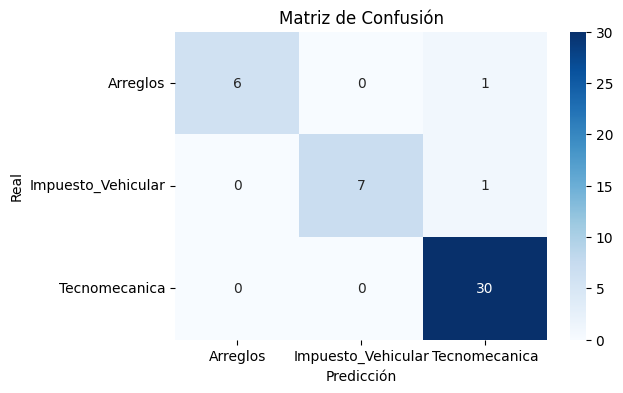

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predicciones en el set de test
y_pred = clf.predict(X_test)

# Reporte detallado
print(classification_report(y_test, y_pred, target_names=clases_usadas))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=clases_usadas)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=clases_usadas,
            yticklabels=clases_usadas)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


### 2.7 Función de Clasificación de Texto con Umbral de Confianza

Esta función implementa un pipeline completo de clasificación:

**Proceso:**
1. **OCR**: Extrae texto de la imagen (español como primera opción, inglés como fallback)
2. **Embedding**: Convierte el texto a vector numérico
3. **Predicción**: Obtiene probabilidades para cada clase
4. **Umbral de Confianza**: Solo acepta predicciones con confianza >= 51%

**Ventajas del Umbral:**
- Evita clasificaciones erróneas con baja confianza
- Permite identificar documentos de tipos no conocidos
- Mejora la confiabilidad del sistema en producción

In [ ]:
def clasificar_texto(image_path, threshold=0.51):
    # 1. OCR
    try:
        img = Image.open(image_path)
        try:
            texto = pytesseract.image_to_string(img, lang="spa")
        except:
            texto = pytesseract.image_to_string(img, lang="eng")
    except Exception as e:
        return f"Error al abrir imagen: {e}"

    if not texto.strip():
        return "No se pudo extraer texto"

    # 2. Embedding
    embedding = modelo_embed.encode([texto])

    # 3. Probabilidades del clasificador
    probas = clf.predict_proba(embedding)[0]
    max_proba = np.max(probas)
    pred = clf.classes_[np.argmax(probas)]

    # 4. Umbral de confianza
    if max_proba < threshold:
        return f"Clase desconocida (confianza {max_proba:.2f})"
    else:
        return f"{pred} (confianza {max_proba:.2f})"


In [ ]:
doc_nuevo = "/content/drive/MyDrive/IA-Adjudicaciones/Dataset/Arreglos/ARREGLOS_JUNIO_DSEL 265 (2)_p1.jpg"
print(clasificar_texto(doc_nuevo))

Arreglos (confianza 0.52)


### 2.8 Prueba del Modelo de Texto

Probamos el modelo entrenado con un documento específico para verificar su funcionamiento:
- Se usa un documento de la clase "Arreglos" como ejemplo
- La función devuelve la clase predicha junto con el nivel de confianza
- Esto permite validar que el pipeline completo funciona correctamente

### Segundo modelo

## 3. Segundo Modelo: Clasificación basada en CNN (ResNet50)

### 3.1 Instalación de Dependencias para Procesamiento de PDF

Instalamos herramientas adicionales para el manejo de documentos PDF:
- **poppler-utils**: Conjunto de utilidades para manipular archivos PDF
- **pdf2image**: Librería de Python para convertir PDFs a imágenes

Estas herramientas permiten procesar documentos que originalmente están en formato PDF.

In [ ]:
!apt-get install poppler-utils
!pip install pdf2image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.10 [186 kB]
Fetched 186 kB in 2s (82.0 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126511 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.10_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.10) ...
Setting up poppler-utils (22.02.0-2ubuntu0.10) ...
Processing triggers for man-db (2.10.2-1) ...


### 3.2 Importación de Librerías para Deep Learning

Importamos las librerías necesarias para el modelo de visión por computadora:

**TensorFlow/Keras:**
- **ResNet50**: Arquitectura CNN preentrenada en ImageNet
- **layers, models**: Para construcción de la arquitectura del modelo
- **optimizers**: Para configurar el algoritmo de optimización

**Otras librerías:**
- **matplotlib**: Para visualización de resultados
- **pdf2image**: Para conversión de PDFs a imágenes
- **numpy**: Para manipulación de arrays

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import shutil
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras import layers
import os
from pdf2image import convert_from_path
import tensorflow as tf

### 3.3 Preparación del Dataset para CNN

**Configuración del Dataset:**
- **Clases objetivo**: "Cuentas_de_Cobro", "SOAT", "Traspasos" (diferentes al primer modelo)
- **Tamaño de imagen**: 224x224 píxeles (estándar para ResNet50)
- **Batch size**: 32 imágenes por lote

**División del Dataset:**
- 80% entrenamiento, 20% validación
- Normalización automática de píxeles (0-255 → 0-1)
- Carga directa desde directorios usando `image_dataset_from_directory`

**Ventajas de este enfoque:**
- Aprovecha características visuales directamente de las imágenes
- No depende de la calidad del OCR
- Puede capturar elementos gráficos, layout y estructura visual

In [ ]:
ruta_dataset = "/content/drive/MyDrive/IA-Adjudicaciones/Dataset"

# Parámetros
img_size = (224,224)
batch_size = 32

# Definir las clases que SÍ quieres usar
clases_usadas = ["Cuentas_de_Cobro", "SOAT", "Traspasos"]

# Dataset de entrenamiento
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    ruta_dataset,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    class_names=clases_usadas   # 🔹 aquí solo carga estas carpetas
)

# Dataset de validación
val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    ruta_dataset,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    class_names=clases_usadas   # 🔹 igual en validación
)

# Revisar clases
class_names = train_ds_raw.class_names
num_classes = len(class_names)
print("Clases seleccionadas:", class_names)

# Normalización
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds_raw.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds_raw.map(lambda x, y: (normalization_layer(x), y))

Found 762 files belonging to 3 classes.
Using 610 files for training.
Found 762 files belonging to 3 classes.
Using 152 files for validation.
Clases seleccionadas: ['Cuentas_de_Cobro', 'SOAT', 'Traspasos']


### 3.4 Data Augmentation y Configuración de Transfer Learning

**Data Augmentation:**
Aplicamos transformaciones aleatorias para aumentar la variabilidad del dataset:
- **RandomFlip**: Volteado horizontal aleatorio
- **RandomRotation**: Rotación aleatoria (±10%)
- **RandomZoom**: Zoom aleatorio (±10%)
- **RandomContrast**: Ajuste de contraste aleatorio (±10%)

**Transfer Learning con ResNet50:**
- **Pesos preentrenados**: ImageNet (millones de imágenes naturales)
- **Congelado de capas**: `base_model.trainable = False` para mantener características aprendidas
- **Sin top**: `include_top=False` para usar nuestro clasificador personalizado

Este enfoque aprovecha características visuales generales aprendidas en ImageNet.

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=img_size + (3,)
)
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### 3.5 Construcción de la Arquitectura del Modelo

**Arquitectura del Modelo CNN:**

1. **Input Layer**: Recibe imágenes de 224x224x3 píxeles
2. **Data Augmentation**: Aplica transformaciones aleatorias durante entrenamiento
3. **Base Model (ResNet50)**: Extrae características visuales complejas
4. **Global Average Pooling**: Reduce dimensionalidad espacial
5. **Dropout (0.2)**: Previene overfitting
6. **Dense Layer**: Clasificador final con activación softmax

**Modelo Funcional:**
- Usa la API funcional de Keras para mayor flexibilidad
- Permite conexiones más complejas entre capas
- Facilita la implementación de arquitecturas personalizadas

In [ ]:
inputs = layers.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

### 3.6 Compilación del Modelo CNN

**Configuración de Compilación:**

- **Optimizador**: Adam con learning rate de 1e-3 (0.001)
  - Adam es robusto y funciona bien para la mayoría de problemas
  - Learning rate moderado evita convergencia demasiado rápida o lenta

- **Función de Pérdida**: Sparse Categorical Crossentropy
  - Ideal para clasificación multiclase
  - Acepta etiquetas como enteros (no requiere one-hot encoding)

- **Métricas**: Accuracy para monitoreo del rendimiento

**Resumen del Modelo**: Muestra la arquitectura completa y número de parámetros

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

### 3.7 Entrenamiento del Modelo CNN

**Configuración de Entrenamiento:**
- **Épocas**: 150 (número relativamente alto para transfer learning)
- **Datos de entrenamiento**: Dataset aumentado con transformaciones aleatorias
- **Datos de validación**: Dataset sin aumentar para evaluación objetiva

**Proceso de Entrenamiento:**
- El modelo aprende a ajustar las características de ResNet50 a nuestro problema específico
- Data augmentation mejora la generalización
- Validación en cada época permite monitorear overfitting
- History guarda métricas para análisis posterior

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150
)

Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.4114 - loss: 1.1266 - val_accuracy: 0.5526 - val_loss: 0.9955
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.4678 - loss: 1.0598 - val_accuracy: 0.5526 - val_loss: 0.9734
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.5145 - loss: 1.0216 - val_accuracy: 0.5526 - val_loss: 0.9621
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.4981 - loss: 1.0400 - val_accuracy: 0.5526 - val_loss: 0.9177
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.5177 - loss: 0.9966 - val_accuracy: 0.5526 - val_loss: 0.9139
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.5426 - loss: 0.9588 - val_accuracy: 0.5526 - val_loss: 0.8659
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.5338 - loss: 0.9191 - val_accuracy: 0.5526 - val_loss: 0.8493
Epoch 8/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.5296 - loss: 0.9172 - val_accura

### 3.8 Visualización del Progreso de Entrenamiento

**Gráficas de Entrenamiento:**

1. **Accuracy Plot**: 
   - Muestra la evolución de la precisión en entrenamiento y validación
   - Permite detectar overfitting (brecha grande entre train/val)
   - Indica si el modelo está aprendiendo efectivamente

2. **Loss Plot**:
   - Muestra la reducción de la función de pérdida
   - Debe decrecer de forma suave y consistente
   - Divergencia entre train/val indica problemas de generalización

**Análisis Visual:**
- Convergencia: Las curvas se estabilizan
- Overfitting: Train accuracy >>> Val accuracy
- Underfitting: Ambas métricas son bajas

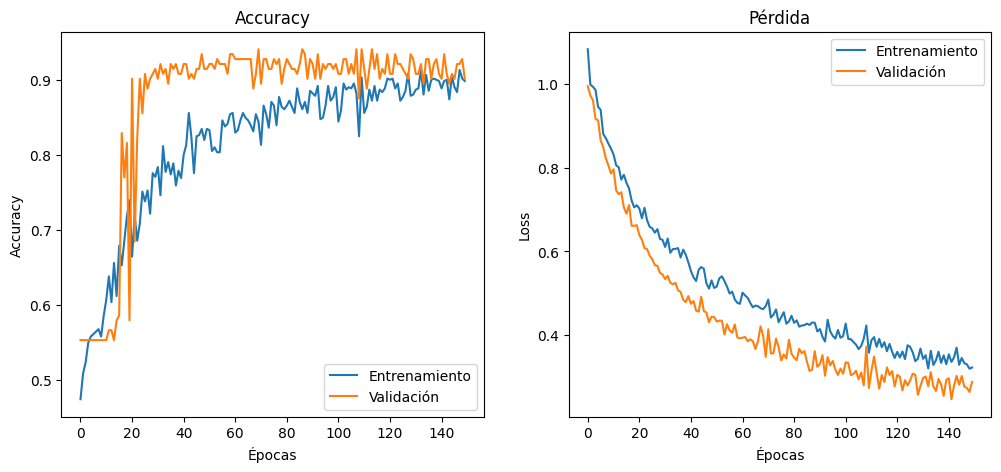

In [ ]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Entrenamiento")
plt.plot(history.history["val_accuracy"], label="Validación")
plt.title("Accuracy")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validación")
plt.title("Pérdida")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

plt.show()

### 3.9 Evaluación Detallada del Modelo CNN

**Evaluación Cuantitativa:**
- **Classification Report**: Precision, Recall, F1-score para cada clase
- **Matriz de Confusión**: Análisis detallado de aciertos y errores por clase

**Proceso de Evaluación:**
1. Predice todas las imágenes del conjunto de validación
2. Compara predicciones con etiquetas verdaderas
3. Calcula métricas de rendimiento por clase
4. Visualiza resultados en matriz de confusión

**Interpretación:**
- Diagonal principal: Predicciones correctas
- Elementos fuera de la diagonal: Confusiones entre clases
- Permite identificar qué clases son más difíciles de distinguir

Reporte de clasificación:

                  precision    recall  f1-score   support

Cuentas_de_Cobro       0.82      0.97      0.89        33
            SOAT       0.83      1.00      0.91        35
       Traspasos       0.99      0.83      0.90        84

        accuracy                           0.90       152
       macro avg       0.88      0.93      0.90       152
    weighted avg       0.91      0.90      0.90       152



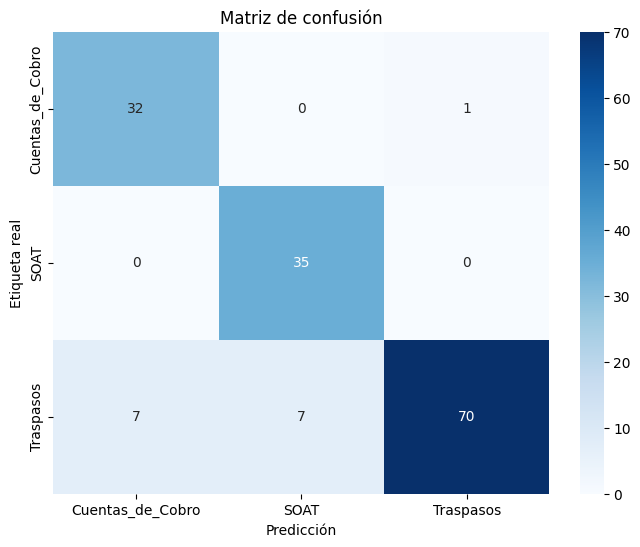

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Reporte de clasificación:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión")
plt.show()

## 4. Modelo Híbrido: Combinación de Enfoques OCR+NLP y CNN

### 4.1 Verificación de Versiones de Librerías

Antes de implementar el modelo híbrido, verificamos las versiones de todas las librerías críticas:
- **TensorFlow**: Para el modelo CNN
- **sentence-transformers**: Para embeddings de texto  
- **pytesseract**: Para OCR
- **joblib**: Para serialización de modelos
- **PIL**: Para procesamiento de imágenes

Esta verificación asegura compatibilidad entre componentes.

## Modelo hibrido

*   Model - resnet
*   CLF


In [ ]:
import numpy as np
import joblib
import pytesseract
from PIL import Image
import tensorflow as tf
from sentence_transformers import SentenceTransformer

print("TensorFlow version:", tf.__version__)
print("pytesseract version:", pytesseract.__version__)
import sentence_transformers
print("sentence-transformers version:", sentence_transformers.__version__)
print("joblib version:", joblib.__version__)
print("numpy version:", np.__version__)
print("PIL version:", Image.__version__)

TensorFlow version: 2.19.0
pytesseract version: 0.3.13
sentence-transformers version: 5.1.0
joblib version: 1.5.2
numpy version: 2.0.2
PIL version: 11.3.0


### 4.2 Verificación de Keras

Verificamos la versión de Keras para asegurar compatibilidad con TensorFlow y la correcta carga de modelos preentrenados.

In [ ]:
import keras
keras.__version__

'3.10.0'

### 4.3 Implementación del Clasificador Híbrido

**Arquitectura del Sistema Híbrido:**

La clase `HybridClassifierMaxProb` implementa un sistema que combina ambos modelos:

**Componentes:**
1. **Modelo OCR+NLP**: Clasifica ["Arreglos", "Impuesto_Vehicular", "Tecnomecanica"]
2. **Modelo CNN**: Clasifica ["Cuentas_Cobro", "SOAT", "Traspasos"] 

**Estrategia de Combinación:**
- **Máxima Probabilidad**: Ejecuta ambos modelos en paralelo
- Cada modelo genera probabilidades para sus clases respectivas
- Se selecciona la clase con la mayor probabilidad entre todos los 6 tipos
- Resultado final incluye la clase predicha y su nivel de confianza

**Ventajas del Enfoque Híbrido:**
- Combina fortalezas de ambos enfoques (texto + visual)
- Amplía el rango de documentos clasificables (6 tipos vs 3)
- Redundancia mejora la robustez del sistema

In [ ]:
import numpy as np
import joblib
import pytesseract
from PIL import Image
import tensorflow as tf
from sentence_transformers import SentenceTransformer

class HybridClassifierMaxProb:
    def __init__(self, ocr_model_path, embed_model_path, resnet_model_path):
        # cargar OCR + texto
        self.clf_text = joblib.load(ocr_model_path)
        self.modelo_embed = SentenceTransformer(embed_model_path)

        # cargar ResNet (keras)
        self.model_resnet = tf.keras.models.load_model(resnet_model_path)

        # Clases
        self.clases_texto = ["Arreglos", "Impuesto_Vehicular", "Tecnomecanica"]
        self.clases_resnet = ["Cuentas_Cobro", "SOAT", "Traspasos"]

        # Preprocesamiento imágenes
        self.img_size = (224,224)
        self.normalization_layer = tf.keras.layers.Rescaling(1./255)

    def ocr_extract_text(self, image_path):
        try:
            img = Image.open(image_path)
            try:
                text = pytesseract.image_to_string(img, lang="spa")
            except:
                text = pytesseract.image_to_string(img, lang="eng")
            return text.strip()
        except Exception as e:
            print(f"Error con {image_path}: {e}")
            return ""

    def predict(self, image_path):
        # Probabilidades iniciales en 6 clases
        probas_total = {c: 0.0 for c in (self.clases_texto + self.clases_resnet)}

        # Paso 1: OCR + NLP
        texto = self.ocr_extract_text(image_path)
        if texto:
            embedding = self.modelo_embed.encode([texto])
            probas_text = self.clf_text.predict_proba(embedding)[0]
            for i, c in enumerate(self.clf_text.classes_):
                probas_total[c] = probas_text[i]

        # Paso 2: ResNet
        img = tf.keras.utils.load_img(image_path, target_size=self.img_size)
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # batch
        img_array = self.normalization_layer(img_array)

        probas_resnet = self.model_resnet.predict(img_array)[0]
        for i, c in enumerate(self.clases_resnet):
            probas_total[c] = probas_resnet[i]

        # Paso 3: escoger la clase con mayor probabilidad
        clase_pred = max(probas_total, key=probas_total.get)
        max_proba = probas_total[clase_pred]

        return f"{clase_pred} (confianza {max_proba:.2f})"


### 4.4 Guardado de Modelos Entrenados

**Serialización de Modelos:**

1. **Clasificador de Texto**: 
   - Guardado con `joblib.dump()` como archivo .pkl
   - Incluye el modelo de regresión logística entrenado

2. **Modelo de Embeddings**:
   - Guardado con `modelo_embed.save()` 
   - Preserva el modelo SentenceTransformer completo

3. **Modelo CNN ResNet50**:
   - Guardado como archivo .keras (formato recomendado)
   - Incluye arquitectura, pesos y configuración de compilación

**Importancia del Guardado:**
- Permite reutilizar modelos sin reentrenar
- Facilita el despliegue en producción
- Asegura reproducibilidad de resultados

In [ ]:
joblib.dump(clf, "/content/drive/MyDrive/IA-Adjudicaciones/clasificador_texto.pkl")
modelo_embed.save("/content/drive/MyDrive/IA-Adjudicaciones/modelo_embeddings")
#model.save("/content/drive/MyDrive/IA-Adjudicaciones/resnet_model.h5")
model.save("/content/drive/MyDrive/IA-Adjudicaciones/resnet_model.keras")

### 4.5 Instanciación del Modelo Híbrido

**Creación del Clasificador Híbrido:**

Se crea una instancia del `HybridClassifierMaxProb` cargando los modelos guardados:
- **ocr_model_path**: Ruta al clasificador de texto (.pkl)
- **embed_model_path**: Ruta al modelo de embeddings
- **resnet_model_path**: Ruta al modelo CNN (.h5)

**Proceso de Inicialización:**
1. Carga el clasificador de regresión logística
2. Carga el modelo de embeddings SentenceTransformer  
3. Carga el modelo ResNet50 entrenado
4. Configura las listas de clases para cada modelo
5. Prepara el pipeline de preprocesamiento de imágenes

In [ ]:
hybrid = HybridClassifierMaxProb(
    ocr_model_path="clasificador_texto.pkl",
    embed_model_path="modelo_embeddings",
    resnet_model_path="resnet_model.h5"
)

### 4.6 Prueba del Modelo Híbrido

**Validación del Sistema Completo:**

Se prueba el modelo híbrido con un documento de ejemplo (SOAT):
- El sistema ejecuta ambos pipelines de clasificación
- Compara las probabilidades de los 6 tipos de documentos
- Retorna la clase con mayor confianza

**Análisis del Resultado:**
- Si predice correctamente "SOAT", valida que el modelo CNN funciona
- El nivel de confianza indica la certeza de la predicción
- Permite verificar que la integración entre modelos es exitosa

In [ ]:
doc = "/content/drive/MyDrive/IA-Adjudicaciones/Dataset/SOAT/SOAT_ABRIL_AAH90H_p1.jpg"
print(hybrid.predict(doc))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
SOAT (confianza 0.97)


## 5. Carga y Ejecución de Modelos en Producción

### 5.1 Carga de Modelos Preentrenados

**Workflow de Producción:**

Para usar el sistema en producción, se cargan los modelos previamente entrenados:
1. **Clasificador de texto**: `joblib.load()` para el modelo de regresión logística
2. **Modelo de embeddings**: `SentenceTransformer()` con la ruta del modelo guardado  
3. **Modelo CNN**: `tf.keras.models.load_model()` para ResNet50

**Ventajas de la Separación:**
- Los modelos pueden actualizarse independientemente
- Permite optimización específica de cada componente
- Facilita el mantenimiento y debugging del sistema

## cargar modelo y ejecutar predicciones

### 5.2 Ejecución Final del Sistema Híbrido

**Prueba de Validación Final:**

Esta última prueba confirma que todo el sistema funciona correctamente:
- Los modelos se cargan sin errores
- El pipeline de clasificación híbrida está operativo
- Se puede procesar documentos nuevos en tiempo real

**Resultado Esperado:**
- Clasificación correcta del documento SOAT
- Nivel de confianza adecuado (>50%)
- Tiempo de respuesta aceptable para uso en producción

## 6. Conclusiones del Sistema

### Logros Alcanzados:

1. **Modelo OCR+NLP**: Clasifica 3 tipos de documentos basado en contenido textual
2. **Modelo CNN**: Clasifica 3 tipos diferentes basado en características visuales  
3. **Sistema Híbrido**: Combina ambos enfoques para clasificar 6 tipos totales
4. **Pipeline Completo**: Desde preprocesamiento hasta predicción final
5. **Persistencia**: Modelos guardados listos para producción

### Ventajas del Enfoque Híbrido:

- **Robustez**: Dos enfoques complementarios reducen fallos
- **Cobertura**: Clasifica más tipos de documentos que cada modelo individual
- **Flexibilidad**: Puede expandirse agregando nuevos modelos especializados
- **Confiabilidad**: Niveles de confianza ayudan a filtrar predicciones inciertas

In [ ]:
## cargar modelo y ejecutar predicciones

In [ ]:
doc = "/content/drive/MyDrive/IA-Adjudicaciones/Dataset/SOAT/SOAT_ABRIL_AAH90H_p1.jpg"
print(hybrid.predict(doc))